# Active Learning for AMR

This project includes data, scripts, and Jupyter notebooks for analysis of performance of Active Learning techniques applied to Adaptive Mesh Refinement (AMR) simulations. Specifially, we consider AMR simulations of a shock-bubble interaction phenomenon (visualization is shown below). We train and evaluate Active Learning algorithms on the data from AMR simulation runs performed on Edison supercomputer at NERSC (US National Energy Research Computing Center). 

#### Contributors:
- Dmitry Duplyakin <dmitry.duplyakin@utah.edu>
- Jed Brown <jed@jedbrown.org>
- Donna Calhoun <donnacalhoun@boisestate.edu>

#### References:
- Active Learning: 
    * Previous work: http://ieeexplore.ieee.org/document/7776508/
    * Active-learning-based surrogate modeling: http://ieeexplore.ieee.org/document/6702683/
    * Survey: http://burrsettles.com/pub/settles.activelearning.pdf
- AMR with ForestClaw: https://arxiv.org/abs/1308.1472
- Edison: http://www.nersc.gov/users/computational-systems/edison/

<img src="shockbubble_example.png" style="height:180px">

### This notebooks applies AL to a dataset obtained from Adaptive Mesh Refinement simulations, considers both computational cost and memory usage as primary evaluation metrics, and characterizes performance and cost trade-offs. 

##### For efficiency, this notebook uses Python's multiprocessing module and processes multiple Active Learning trajectories (i.e. instantiations of Active Learning on randomly shuffled dataset partitions) in parallel.

In [1]:
import os, sys, glob, datetime, logging, time, shutil, random, socket
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from matplotlib import gridspec
import seaborn as sns
from sklearn import preprocessing
from collections import OrderedDict
import ipywidgets as widgets
from IPython.display import display
import multiprocessing as mp
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
from IPython.display import Markdown, display
import hashlib

# Disable scikit-learn warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

# include custom handy, lib-like code
sys.path.append("lib/")
from general import *
from timing import *

# the rest of the code in the cell defines global settings and configurations

# Enable/disable verbose output 
debug = True

%matplotlib inline
# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Choose seaborn style
sns.set_style("whitegrid")

# Configure logging 
LOG = logging.getLogger()
if not len(LOG.handlers):
    console = logging.StreamHandler()
    LOG.addHandler(console)    
LOG.handlers[0].setFormatter(logging.Formatter("%(asctime)s - %(levelname)-7s - %(message)s")) 
LOG.setLevel(logging.DEBUG if debug else logging.INFO)
## Usage: LOG.debug("Debug message") or LOG.warning("Warning message") or LOG.error("Error Message")

# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# Define helper functions
def save_and_show(fig, file_name, dest_dir="./"):
    """ Save given figure object as pdf with the given name inside the given directory"""
    dest_file = os.path.join(dest_dir, file_name)
    fig.savefig(dest_file, bbox_inches='tight')
    print "Saved plot as: %s" % dest_file

### Start new analysis and create unique directory for it or reuse existing one

In [2]:
# If non-empty path is passed to init_experiment(), an existing experiment directory will be reused.
# Otherwise, a new empty experiment directory is created.
out_dir = init_experiment(path="", main_dir="log")

All experiment output will be saved to:
/notebooks/ActiveLearning-For-AMR/active-shockbubble/log/20180225_183635


### Load and preprocess the dataset

- Preprocessing below includes defining the cost of experiments, scaling features to unit cube, log-transforming the cost, etc.
- To avoid using potentially bad measurements, we exclude jobs with MaxRSS == 0
- Add unique hash to each sample  

In [3]:
# Load dataset

# After preprocessing and filtering, we obtained a dataset with 600 jobs (all with non-zero MaxRSS) in jobs/jobs.csv 
# Features (p, mx, max, r0, rhoin) are scaled to unit cube
# Cost ("Cost", in node-hours) and memory usage ("MaxRSS", in bytes) responses are log10-transformed
# Cost is defined as: runtime * node_count / 3600.0 (calculate before node_count is scaled)
# Unnecessary columns are excluded; each sample is assigned a unique hash for convenient further processing & lookups

jobs_path = "jobs/jobs.csv"
jobs = pd.read_csv(jobs_path)
print "Number of loaded jobs: %d" % len(jobs)

jobs.sample(20).T

Number of loaded jobs: 600


,93,309,599,597,187,222,271,361,334,287,344,564,588,276,214,234,340,32,566,153
p,4,16,8,16,16,16,8,8,8,16,16,32,8,16,16,16,16,16,32,8
mx,16,32,32,32,8,32,32,8,32,8,32,32,32,32,8,32,8,8,16,16
max,6,5,6,6,4,3,4,3,5,3,5,6,6,4,4,3,4,4,6,6
r0,0.5,0.2,0.5,0.2,0.5,0.5,0.4,0.3,0.2,0.4,0.2,0.3,0.5,0.2,0.3,0.3,0.5,0.4,0.2,0.5
rhoin,0.05,0.025,0.4,0.1,0.4,0.1,0.1,0.1,0.05,0.1,0.1,0.1,0.1,0.05,0.025,0.05,0.2,0.1,0.4,0.4
Cost,0.068594,-0.00644425,0.402204,0.376778,-1.69525,-0.592257,-0.565587,-2.344,-0.235094,-2.02593,0.0359649,0.663842,0.896652,-0.289251,-1.65229,-0.598454,-1.71489,-1.71537,-0.13238,-0.377176
MaxRSS,7.30318,7.03511,7.18939,7.05468,5.60359,7.06598,5.47568,6.65846,7.02933,6.43125,7.04017,7.06979,7.50949,7.04195,6.4319,6.65217,6.44868,6.43779,5.92623,7.00716
WALLTIME,1053.99,221.686,1136.1,535.748,4.5387,57.5341,122.356,2.03802,261.89,2.11957,244.426,518.793,3547.03,115.593,5.01061,56.719,4.33802,4.33326,82.9416,188.815
hash,fc5d298d16b3,2735f0e1755d,8384115038f5,9da29d42f6a6,31d003d70ec5,a676e702bf2f,5d28518fa15b,3a8b919b777d,b268f1a590b2,d0a34a581ce6,82b99f40f52b,b5397781c8d7,23b2c081c455,361dac76d96b,55620f90aede,bc6d41df11c2,6287e3aa594b,1d72252af187,46d04ff5e074,58cb1f8cfa47


In [4]:
# Print stats for different responses

print "Stats for responses (unscaled, untransformed):"
response_stats = pd.concat([(10 ** jobs["MaxRSS"] / (1024 ** 2)).describe(), 
           (10 ** jobs["Cost"]).describe(), 
           (jobs["WALLTIME"]).describe()], axis=1).T[["min", "50%", "mean", "max"]]
response_stats

Stats for responses (unscaled, untransformed):


,min,50%,mean,max
MaxRSS,0.015625,8.003906,7.537526,32.558594
Cost,0.002192,0.248903,0.810211,11.852711
WALLTIME,1.972950,96.890950,240.250878,4262.730000


In [5]:
# For convenience, define handy labels, mappings, and so on

cost_response = "Cost"
mem_response = "MaxRSS"

all_labels={'max': 'Maximum Refinement Level',
            'mx': 'Grid Size',
            'p': 'Number of Processors',
            'r0': 'Bubble Size',
            'rhoin': 'Bubble Density',
            'WALLTIME': 'Runtime, s',
            'Cost': 'log(Cost, Node-Hours)',
            'MaxRSS': 'log(Maximum Memory Usage Per Process, Bytes)'}

cost_response_label = all_labels[cost_response]
mem_response_label = all_labels[mem_response]

features = ["p", "mx", "max", "r0", "rhoin"]
feature_labels = OrderedDict([(f, all_labels[f]) for f in features])

xlabels = [v for k,v in feature_labels.iteritems()]
xylabels = xlabels + [cost_response_label]

In [6]:
# Show stats for feature values (unscaled) 

# Dataset in jobs/jobs.csv has unscaled features and responses along with all available additional columns
# (all data recorded in SLURM for those jobs). To see all columns: `print jobs_raw.columns`

jobs_raw_path = "jobs/jobs_raw.csv"
jobs_raw = pd.read_csv(jobs_raw_path)
print "Number of loaded jobs: %d" % len(jobs_raw)

print "Stats for features (unscaled, untransformed):"
feature_stats = jobs_raw[features].describe().T[["min", "50%", "mean", "max"]]
feature_stats

Number of loaded jobs: 600
Stats for features (unscaled, untransformed):


,min,50%,mean,max
p,4.00,8.0,12.766667,32.0
mx,8.00,16.0,20.666667,32.0
max,3.00,5.0,4.715000,6.0
r0,0.20,0.3,0.339833,0.5
rhoin,0.02,0.1,0.160817,0.5


In [7]:
# Print stats for unscaled features and responses as a table for the paper
pd.concat([feature_stats, response_stats])

,min,50%,mean,max
p,4.000000,8.000000,12.766667,32.000000
mx,8.000000,16.000000,20.666667,32.000000
max,3.000000,5.000000,4.715000,6.000000
r0,0.200000,0.300000,0.339833,0.500000
rhoin,0.020000,0.100000,0.160817,0.500000
MaxRSS,0.015625,8.003906,7.537526,32.558594
Cost,0.002192,0.248903,0.810211,11.852711
WALLTIME,1.972950,96.890950,240.250878,4262.730000


In [8]:
# Largest Cost / Smallest Cost
response_stats.loc["Cost"].max() / response_stats.loc["Cost"].min()

5406.8476139990798

In [9]:
# Find unique parameter configurations

total_config_count = 1
for f in features:
    total_config_count *= len(jobs[f].unique())
print "Number of all possible combinations of selected feture values: ", total_config_count

unique_count = len(jobs.groupby(features))
print "Number of unique configurations represented in the jobs dataset: ", unique_count
print "Number of jobs that are repeated trials for already sampled configurations: ", len(jobs) - unique_count
    
print "\nNumber of trials for a single configuration (value counts):\n", jobs.groupby(features).size().value_counts()

print "Ratio of studied configurations over total: ", 1.0 * unique_count / total_config_count

Number of all possible combinations of selected feture values:  1920
Number of unique configurations represented in the jobs dataset:  525
Number of jobs that are repeated trials for already sampled configurations:  75

Number of trials for a single configuration (value counts):
1    453
2     69
3      3
dtype: int64
Ratio of studied configurations over total:  0.2734375


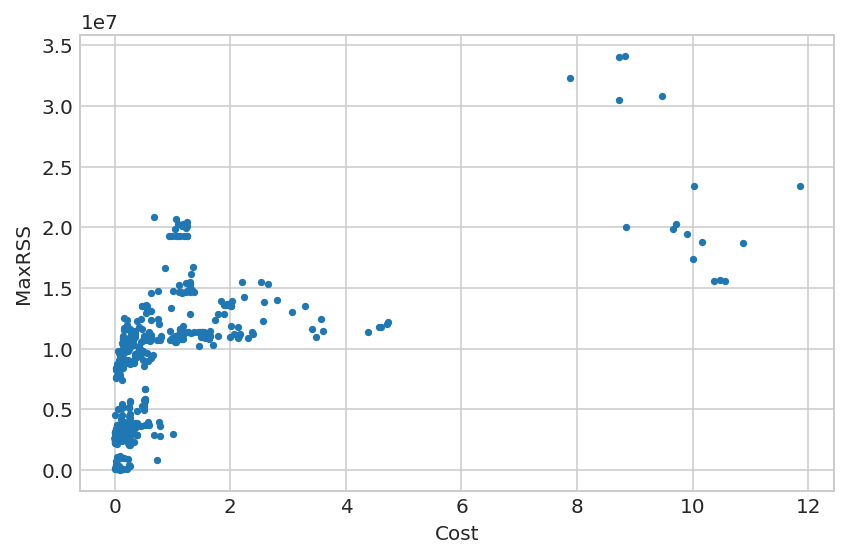

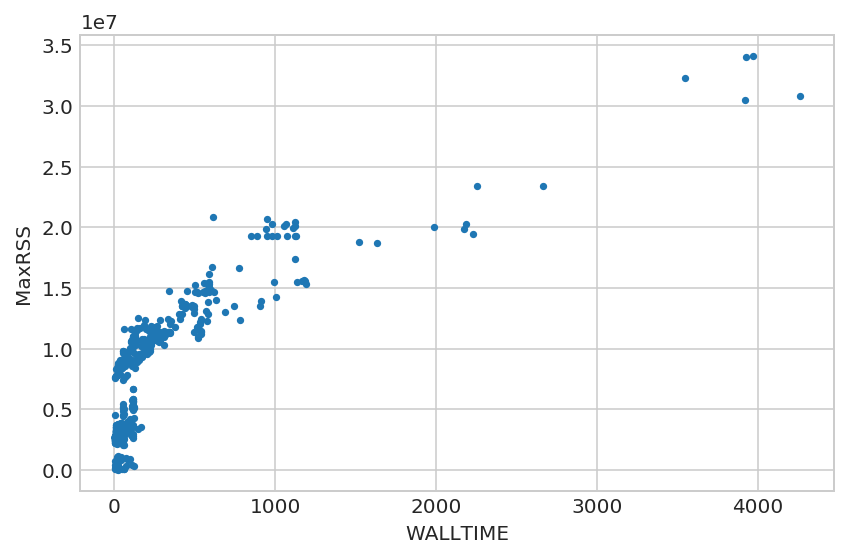

In [10]:
# Plot relationships between cost, walltime, and memory usage

jobs_plot = jobs.copy()

# Optionally, convert responses back to original units (node-hours and bytes)
jobs_plot['Cost'] = 10 ** jobs_plot['Cost']
jobs_plot['MaxRSS'] = 10 ** jobs_plot['MaxRSS']

for x in ['Cost', 'WALLTIME']:
    fig, ax = plt.subplots(sharey=False)
    jobs_plot.plot.scatter(x=x, y=mem_response, s=7.0, ax=ax);
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    fig.tight_layout()

,0,1,2,3,4,5,6,7,8,9
Job Count,280.0,282.00,304.00,357.00,503.00,540.00,569.00,588.00,595.00,595.00
Relative Memory Limit,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99


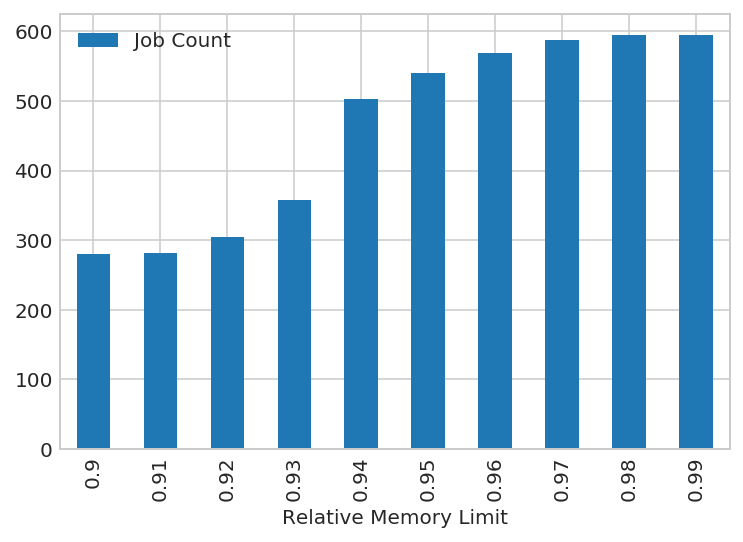

In [11]:
# Check memory usage distribution: 
# How many jobs satisy a specific memory constraint expressed as a perecentage of the maximum reported memory usage?

# This analysis shows that with 95% relative memory limit, there are 540 jobs that satisfy this limit

job_counts = []
mem_limit_rel_list = np.arange(10) * 0.01 + 0.9
for mem_limit_rel in mem_limit_rel_list:
    mem_limit_abs = jobs["MaxRSS"].max() * mem_limit_rel
    job_counts.append(len(jobs[jobs["MaxRSS"] <= mem_limit_abs]))

job_counts = pd.DataFrame({'Relative Memory Limit': mem_limit_rel_list, 'Job Count': job_counts})

job_counts.plot.bar(x='Relative Memory Limit')
job_counts.T

### Define a partitioning scheme which considers memory limit, init/active ratio, and number of test points

In [12]:
def get_ordered_copy(df, shuffle=False):
    """ Helper function that creates a copy of a given dataframe df; before returning, 
    this function reindexes the copy so it has index values from 0 to len(df). Shuffling is optional.
    """
    df_tmp = df.copy()
    n = len(df_tmp)
    df_tmp.set_index(np.arange(n), inplace=True) 
    
    if shuffle:
        df_shuffled = df_tmp.reindex(np.random.permutation(n)).set_index(np.arange(n))
        return df_shuffled
    else:
        df_tmp.set_index(np.arange(n))
        return df_tmp

def get_partition(df, mem_limit_rel=0.95, n_test_abs=200, n_init_rel=0.1, verbose=False, save=False):
    """ Return dataframes for Init, Active, and Test subsets for a single random partition of the given dataframe df.
    
    mem_limit_rel -- coefficient between 0 and 1 which sets the memory limit to be considred by Active Learning;
                     absolute memory limit is set to: mem_limit_rel * [max reported memory usage in df] 
    n_test_abs -- fixed number of jobs that are set aside into the Test partition; 
                  all test jobs should satisfy the selected memory limit
    n_init_rel -- within the pool of remaining (n-n_test_abs) jobs, select this percentage of jobs to be 
                  in the Init partion; should be between 0 and 1
    save -- If set, partition dataframes will be saved to csv files.
    """
    df_tmp = df.copy()
    
    n = len(df_tmp)
    mem_limit_abs = df_tmp["MaxRSS"].max() * mem_limit_rel
    if verbose: 
        print "Absolute memory limit:", mem_limit_abs
    
    df_tmp['MemoryUsage'] = df_tmp['MaxRSS'].apply(lambda x: "Satisfying" if x <= mem_limit_abs else "Exceeding")
    if verbose: 
        print "Distribution of jobs by memory usage class:"
        print pd.value_counts(df_tmp['MemoryUsage'])
    
    # Split into classes of memory usage (use shuffling!)
    df_satisfying = get_ordered_copy(df_tmp[df_tmp['MemoryUsage'] == "Satisfying"], shuffle=True)
    df_exceeding = get_ordered_copy(df_tmp[df_tmp['MemoryUsage'] == "Exceeding"], shuffle=True)
    
    # Check if desired partitioning is feasible 
    if len(df_satisfying) <= n_test_abs:
        LOG.error("Not enough satisfying jobs for the desired analysis. Consider increasing mem_limit_rel.")
        return None 
    
    # Only satisfting jobs in Test partition
    test = get_ordered_copy(df_satisfying[:n_test_abs])
    
    remaining_pool = get_ordered_copy(pd.concat([df_exceeding, get_ordered_copy(df_satisfying[n_test_abs:])]), 
                                      shuffle=True)
    
    n_init_abs = int(n_init_rel * len(remaining_pool)) 
    init = get_ordered_copy(remaining_pool[:n_init_abs])
    active = get_ordered_copy(remaining_pool[n_init_abs:])
    
    if save:
        init.to_csv(os.path.join(out_dir, 'init.csv'))
        active.to_csv(os.path.join(out_dir, 'active.csv'))
        test.to_csv(os.path.join(out_dir, 'test.csv'))
    
    if verbose:
        print "Init partition:\t\t(Total: %d),\t(Satisfying: %d),\t(Exceeding: %d)" % \
            (len(init), len(init[init['MemoryUsage'] == "Satisfying"]), 
             len(init[init['MemoryUsage'] == "Exceeding"]))
        print "Active partition:\t(Total: %d),\t(Satisfying: %d),\t(Exceeding: %d)" % \
            (len(active), len(active[active['MemoryUsage'] == "Satisfying"]), 
             len(active[active['MemoryUsage'] == "Exceeding"]))
        print "Test partition:\t\t(Total: %d),\t(Satisfying: %d),\t(Exceeding: %d)" % \
            (len(test), len(test[test['MemoryUsage'] == "Satisfying"]), 
             len(test[test['MemoryUsage'] == "Exceeding"])) 

    return (init, active, test)

(init, active, test) = get_partition(jobs, n_init_rel=0.1, mem_limit_rel=0.95, verbose=True)
n_init = len(init)
n_active = len(active)
n_test = len(test)

if n_init + n_active + n_test != len(jobs):
    LOG.warning("Size of partitions do not add up to the total number of jobs")

Absolute memory limit: 7.15660227452
Distribution of jobs by memory usage class:
Satisfying    540
Exceeding      60
Name: MemoryUsage, dtype: int64
Init partition:		(Total: 40),	(Satisfying: 35),	(Exceeding: 5)
Active partition:	(Total: 360),	(Satisfying: 305),	(Exceeding: 55)
Test partition:		(Total: 200),	(Satisfying: 200),	(Exceeding: 0)


Saved plot as: /notebooks/ActiveLearning-For-AMR/active-shockbubble/log/20180225_183635/partitions.pdf


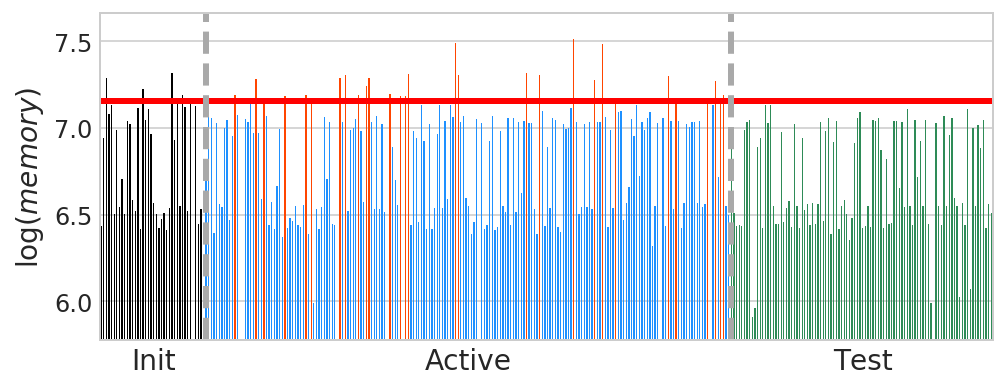

In [13]:
# Visualize partitions

mem_limit_rel = 0.95
mem_limit_abs = jobs["MaxRSS"].max() * mem_limit_rel

sample_count = 100
init_s = init.head(sample_count)
init_s["color"] = "black"
active_s = active.head(sample_count * 2)
active_s["color"] = "dodgerblue"
test_s = test.head(sample_count)
test_s["color"] = "seagreen"

sample_plot = get_ordered_copy(
    pd.concat([init_s, active_s, test_s]), 
    shuffle=False)

# Apply special color to exceeding jobs in Active partition
exc_active_idx = sample_plot[(sample_plot["MemoryUsage"] == "Exceeding") & (sample_plot["color"] == "dodgerblue")].index
sample_plot.loc[exc_active_idx, "color"] = "orangered"
#print sample_plot.color.value_counts()

fig, ax = plt.subplots(figsize=(8, 3))
ax.tick_params(axis='y', labelsize=12)
    
sample_plot[["MaxRSS"]].plot(kind='bar', legend=False, lw=0.0, color=[sample_plot["color"]], ax=ax)
ax.axhline(y=mem_limit_abs, linewidth=3, color = 'r')

# Additional styling
ax.set_ylabel("log($memory$)", fontsize=14)
ax.set_ylim(sample_plot["MaxRSS"].min() * 1.2, 1.02 * active_s["MaxRSS"].max())
ax.axvline(x=len(init_s), linewidth=3, linestyle="dashed", color = 'darkgrey')
ax.axvline(x=len(init_s)+len(active_s), linewidth=3, linestyle="dashed", color = 'darkgrey')
ax.xaxis.set_ticks([len(init_s)/2.0, len(init_s) + len(active_s)/2.0, len(init_s) + len(active_s) + len(test_s)/2.0])
ax.xaxis.set_ticklabels(["Init", "Active", "Test"])
plt.xticks(rotation=0)
ax.tick_params(axis='x', labelsize=14)
ax.xaxis.grid(False)

save_and_show(fig, "partitions.pdf", out_dir)

In [14]:
print "Max memory usage in jobs_raw: ", jobs_raw["MaxRSS"].max()
print "Max memory usage in jobs: ", jobs["MaxRSS"].max()

print "Selected relative coefficient: ", mem_limit_rel
print "Absolute non-log limit, Bytes: ", 10 ** mem_limit_abs
print "Absolute non-log limit, MB: ", (10 ** mem_limit_abs) / (1024 ** 2)
print "Absolute non-log limit, Bytes / max memory non-log usage in jobs_raw, Bytes: ", 10**mem_limit_abs / jobs_raw["MaxRSS"].max()

Max memory usage in jobs_raw:  34140160.0
Max memory usage in jobs:  7.53326555213
Selected relative coefficient:  0.95
Absolute non-log limit, Bytes:  14341754.1857
Absolute non-log limit, MB:  13.6773626191
Absolute non-log limit, Bytes / max memory non-log usage in jobs_raw, Bytes:  0.420084562746


### Define learning algorithms and run a small test

In [15]:
def get_xy(df, y_column=""):        
    """ Pull out X (features) and Y (one of the responses) as matrices from the given dataframe"""
    X = df.as_matrix(features)  
    if not y_column:
        # If y_column is not specified, attempt to use cost_response as a default
        Y = df.as_matrix([cost_response]) 
    else:
        Y = df.as_matrix([y_column])
    return (X, Y)

def get_p(X):        
    """ From a given matrix X, pull out the column vector p -- number of processors;
    Order of the column p corresponds to its order in features
    """
    return X[:, features.index("p")]

def default_gpr_kernel():
    """ Define GPR kernel with specific shape and boundaries. 
    Use theta as a starting point if specified
    For anisotropic kernels with N-dimensional fitting, provide length_scale as a vector with N components"""
    return C(constant_value=1.0, constant_value_bounds=(1e-3, 1e3))\
          * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))\
          + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e+3))

def init_learn(df, response="", opt_restarts=1, verbose=False):
    """ Find a fit for the specified response (or default) in the given dataset. """
    gpr = GaussianProcessRegressor(kernel = default_gpr_kernel(), 
                                   n_restarts_optimizer = opt_restarts, copy_X_train = False)
    if not response:
        X, Y = get_xy(df)
    else:
        X, Y = get_xy(df, y_column=response)
    
    #gpr_fit(gpr, X, Y)
    gpr.fit(X,Y)
    
    if verbose:
        print "Completed fitting on Initial partition. Hyperparameters: ", gpr.kernel_.theta
    
    return gpr

def record_predictions(df, sigma, pred, cost):
    """ Appends sigma, pred, and true cost to the given dataframe"""
    state = pd.DataFrame( np.concatenate((np.arange(len(sigma)).reshape(-1,1),\
                                          sigma.reshape(-1,1),\
                                          pred.reshape(-1,1),\
                                          cost.reshape(-1,1)),\
                                          axis=1), \
                           columns=["Id","Sigma", "Pred", "True Cost"])
    return df.append(state)
    
def RandUniform(X, pred, sigma, **kwargs):
    """ Random selection: pick a random experiment as a base implementation;
    Optional keyword arguments are included in kwargs
    
    Returns: tuple (index value, error message); message is empty if index is successfully selected.
    
    Previously named: find_random"""
    return (int(np.random.uniform() * len(sigma)), "")

def MaxSigma(X, pred, sigma, **kwargs):
    """ Variance Reduction: find the largest sigma;
    Optional keyword arguments are included in kwargs
    
    Returns: tuple (index value, error message); message is empty if index is successfully selected.
    
    Previously named: find_max_variance"""
    return (np.argmax(sigma), "")

def MinPred(X, pred, sigma, **kwargs):
    """ Cost Efficiency: find the largest sigma/pred;
    Optional keyword arguments are included in kwargs
    
    Expecting the following keys in kwargs: 
        - cost_weight: coefficient in front of the predicted experiment cost (Default: 1.0)
        
    Returns: tuple (index value, error message); message is empty if index is successfully selected.
        
    Previously named: find_max_variance_cost_ratio"""
    cost_weight = kwargs['cost_weight'] if kwargs.has_key('cost_weight') else 1.0
    return (np.argmax(sigma - cost_weight * pred), "")

def RandGoodness(X, pred, sigma, **kwargs):
    """ Active Learning that samples relative value of experiments experssed as goodness=sigma-pred 
    (in log-transformed space, this is equivalent to sigma/pred ratio) 
    
    Tunable params:
    - kwargs["power_base"] -- power base in calculating the candidate "goodness" (Default: 10.0)  
    
    Returns: tuple (index value, error message); message is empty if index is successfully selected.
    
    Previously named: find_sample_value"""
    b = kwargs['power_base'] if kwargs.has_key('power_base') else 10.0
    
    g = b**(sigma-pred) 
    # Probabilities need to add up to 1
    gn = g / np.sum(g)
    idx = np.random.choice(len(gn), p=gn.flatten())
    
    # Older code acomplished the same goal using the code:
    #g_cc = np.cumsum(g)
    #r = np.random.uniform(low=0, high=g_cc[-1])
    #idx = BinarySearch(g_cc, r)
    #idx = np.searchsorted(g_cc, r)
    
    return (idx, "") 

def RGMA(X, pred, sigma, **kwargs):
    """ Active Learning that samples relative value of experiments experessed as goodness=sigma-pred 
    (in log-transformed space, this is equivalent to sigma/pred ratio) 
    
    RGMA -- RandomGoodness with Memory Awareness
    
    This selection considers memory constraints: if mem_pred is larger than memory limit,
    such jobs are avoided.
    
    Tunable params:
    - kwargs["power_base"] -- power base in calculating the candidate "goodness" (Default: 10.0)  
    - kwargs ['mem_limit_abs'] -- memory limit that should be considered in Active Learning (avoid jobs that 
                                  have memory usage predictons that are larger than this limit)
                                  
    kwargs['hash'] -- should be a dataframe with hashes of samples corresponding to rows win X
    kwargs['hash_map'] -- this dataframe will be modified (in place) to include info about
                          whether samples are satisfying or exceeding according to current predictions 
    kwargs['skip_ratio'] -- this parameter helps stop when early, when only there are only 
                            active_set_size * skip_ratio candidates left; valid values are in (0,1)
    
    Returns: tuple (index value, error message); message is empty if index is successfully selected.
    
    Previously named: find_sample_value"""
    b = kwargs['power_base'] if kwargs.has_key('power_base') else 10.0
    
    # Process args with no defaults
    if kwargs.has_key('mem_limit_abs'):
        mem_limit_abs = kwargs ['mem_limit_abs']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: mem_limit_abs")
    if kwargs.has_key('mem_pred'):
        mem_pred = kwargs ['mem_pred']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: mem_pred")
        
    if kwargs.has_key('skip_ratio'):
        skip_ratio = kwargs ['skip_ratio']
    else:
        skip_ratio = 0.1
    
    if len(mem_pred) != len(pred):
        print "RandGoodnessMemAware:\
        Sizes of prediction vectors for cost and memory do not match. Something is going wrong."
    
    if len(kwargs['hash']) != len(pred):
        print "RandGoodnessMemAware:\
        Sizes of prediction and hash vectors do not match. Something is going wrong." 
    
    candidate_mask = (mem_pred < mem_limit_abs).flatten()
    original_order = np.arange(len(candidate_mask))
    
    # In hash_map, interpret T as Satysfying sample, and F as Exceeding
    for i in range(len(kwargs['hash'])):
        kwargs['hash_map'].loc[i] = [kwargs['hash'][i][0], candidate_mask[i]]

    # Check if there are any good candidates; interpret bools as 0s and 1s
    if sum(candidate_mask) == 0:
        return (0, "No available candidate satisfies memory limit.")
    
    if len(candidate_mask) < skip_ratio * len(kwargs['active']):
        return (0, "Exiting because of skip_ratio.")

    # print "Number of satisfying candidates: ", sum(candidate_mask)

    pred_candidates = pred[candidate_mask]
    sigma_candidates = sigma[candidate_mask]

    g = b**(pred_candidates-sigma_candidates).flatten() 
    # Probabilities need to add up to 1
    gn = g / np.sum(g)

    idx_candidate = np.random.choice(len(gn), p=gn)

    # Convert idx_candidate (index in the subset of satisfying jobs) to 
    # idx (index in the original, full set with both satisfying and exceeding jobs)
    idx = original_order[candidate_mask][idx_candidate]

    return (idx, "")

def estimate_error(gpr, X_test, Y_test, convert_to_nonlog=True, base=10.0):
    """ Basic implementation: RMSE - root-mean-square error for response predictions
    
    This function works for estimating both cost and memory model errors.
    For cost: gpr=gpr_cost, Y_test=Y_test
    For memory: gpr=gpr_memory, Y_test=M_test
    
    convert_to_nonlog -- defines whether predictions and Y_test are converted back to non-log values or not
    base -- log based in pre-processing
    """
    #pred = gpr_predict(gpr, X_test, std = False)
    pred = gpr.predict(X_test, return_std = False)
    
    if convert_to_nonlog:
        err = np.sqrt(np.average(np.square(np.power(base,pred) - np.power(base,Y_test))))
    else:
        err = np.sqrt(np.average(np.square(pred - Y_test)))
    return err

def estimate_aggr_stdev(gpr, X_active):
    """ Returns averaged uncertainty for predictions on the entire Active set """
    #pred, std = gpr_predict(gpr, X_active)
    pred, std = gpr.predict(X_active, return_std = True)
    
    sigma_avg = np.average(std)
    # LOG.debug("Arithmetic mean of St.Dev. on Active set: %s" % (sigma_avg))
    return sigma_avg

def get_current_cost(cost_init, cost_active):
    """ For given numpy vectors with active and init experiment costs, returns total cost"""
    
    # Trasform back to non-log costs (to avoid negative values for small jobs)
    total = np.sum(10**cost_active) + np.sum(10**cost_init)   
        
    return total
    
def active_learn(**kwargs):
    """ Active Learning procedure: 
    
        Start with the given initial GPR model and start the loop:
        - from the dataframe active, choose one experiment using the specified algorithm 
        - add this experiment to the used set and remove it from the active set
        - retrain the model
        This loop stops when the active set is empty or the specified iteration limit is reached.
        
        It is convenient to deal with the varying number of arguments where all arguments 
        are wrapped into the kwargs dictionary. This disctionary will be passed to the 
        specified candidate selection function. 
        
        Expecting the following keys and the corresponding values in kwargs: 
        - init: dataframe with Init subset;
                used to train the model every iteration on the combined set: Init + <part of active learned so far>; 
        - active:  dataframe with Active subset; 
        - test:  dataframe with Test subset; 
        - gpr_cost: GPR model trained on cost response in the Init partition
        - gpr_memory: GPR model trained on memory response in the Init partition
        - restarts: number of random restarts in the fit optimizer; passed to the GaussianProcessRegressor.fit()
                    (Default: 1);
        - reuse_kernel: if set, pass optimized kernel from each iteration to the next; otherwise, use defult kernel
                         (Default: True);
        - stop_after_iter: if set, AL will stop at the specified iteration (Default: None);
        - stop_after_cost: if set, AL will stop at the specified cost (Default: None);
        - return_iterations - if a list is provided (regular list or numpy array), 
                              it will be interpreted as a list of
                              specific iterations for which the fitted GPRs will be returned; 
                              In such cases, second returned value will a list of tuples: 
                              (iteration, gpr, X_aggr, Y_aggr), 
                              where the last two components represent the data on which the particular gpr is trained 
                              (points from init combined with the active subset learned so far)
                              (Default: None);
        - record_progress_file - if provided, AL progress will be recorded in this file 
                                 (for long experiments, this is a better way display progress than cell output 
                                 which may not show up after disconnects)
                                 (Default: None);
        - record_progress_rate - if record_progress_file is provided, this rate will be used as the number of AL 
                                 iterations between recordings (Default: 20);
        - record_predictions_at - if number is specified, predictions dataframe will be returned as the 3rd argument;
                                  nothing happens if None is passed (Default: None);
        - mem_limit_abs -- memory limit that should be considered in Active Learning (avoid jobs that 
                           have memory usage predictons that are larger than this limit). Default: not specified
        - verbose - print additional useful info (Default: False) 

        Candidate selection arguments:
        kwargs should also include keys such as: 'label', 'function', 'cost_weight', etc.
        without separating them, the entire kwargs will be passed to the functions referred to with kwargs['function']
        (those functions are expected to do their own error checking if necessary)
        
        Returns a tuple with three components:
        - summary - dataframe where rows are experiments selected at each iteration of AL
        - recordings - list of tuples (iteration, gpr, X_aggr, Y_aggr) for interations specified in return_iterations;
                       empty list if return_iterations is empty
        - predictions - dataframe with sigma, pred, true cost, etc. saved at iteration 
                        specified in record_predictions_at; empty dataframe with record_predictions_at is not set. 
    """
    
    # Process args with no defaults
    if kwargs.has_key('init'):
        init = kwargs ['init']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: init")
    if kwargs.has_key('active'):
        active = kwargs ['active']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: active")   
    if kwargs.has_key('test'):
        test = kwargs ['test']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: test")
    if kwargs.has_key('gpr_cost'):
        gpr_cost_init = kwargs ['gpr_cost']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: gpr_cost")
    if kwargs.has_key('gpr_memory'):
        gpr_memory_init = kwargs ['gpr_memory']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: gpr_memory")
    if kwargs.has_key('function'):
        algorithm_function = kwargs ['function']
    else:
        LOG.error("Active Learning procedure's args dict need to include key: function")
    
    # Process args with default values
    restarts = kwargs['restarts'] if kwargs.has_key('restarts') else 1
    reuse_kernel = kwargs['reuse_kernel'] if kwargs.has_key('reuse_kernel') else True
    stop_after_iter = kwargs['stop_after_iter'] if kwargs.has_key('stop_after_iter') else False
    stop_after_cost = kwargs['stop_after_cost'] if kwargs.has_key('stop_after_cost') else False
    return_iterations = kwargs['return_iterations'] if kwargs.has_key('return_iterations') else None
    record_progress_file = kwargs['record_progress_file'] if kwargs.has_key('record_progress_file') else None
    record_progress_rate = kwargs['record_progress_rate'] if kwargs.has_key('record_progress_rate') else 20
    record_predictions_at = kwargs['record_predictions_at'] if kwargs.has_key('record_predictions_at') else None
    verbose = kwargs['verbose'] if kwargs.has_key('verbose') else False
    mem_limit_abs = kwargs['mem_limit_abs'] if kwargs.has_key('mem_limit_abs') else None

    predictions = pd.DataFrame()
    recordings = []
    
    hash_map = pd.DataFrame() 
    
    return_confirmed = False
    if isinstance(return_iterations, (np.ndarray, list)) and len(return_iterations) > 0:
        return_confirmed = True
    
    gpr_cost = gpr_cost_init
    gpr_memory = gpr_memory_init
    X, Y = get_xy(active)
    _, M = get_xy(active, y_column="MaxRSS")
    X_active = X
    M_active = M
    _, Hash = get_xy(active, y_column="hash")  
    
    X_init, Y_init = get_xy(init)
    _, M_init = get_xy(init, y_column="MaxRSS")
    X_test, Y_test = get_xy(test)
    _, M_test = get_xy(test, y_column="MaxRSS")

    # Empty arrays for points that will be actively learned
    X_learned = np.empty(shape=[0, X.shape[1]])
    Y_learned = np.empty(shape=[0, 1])
    M_learned = np.empty(shape=[0, 1])
    
    # The following vectors contain values obtained at each step of AL
    # (and aligned with new consequtive pairs (x,y) in X_learned and Y_learned)
    # P - prediction at x for cost
    # S - predictive sigma at x for cost
    # PM - prediction at x for memory
    # SM - max sigma
    # Cost_Err - measure of prediction error (i.e. RMSE) on Test partition for cost  
    # Mem_Err -- measure of prediction error (i.e. RMSE) on Test partition for memory
    # H - vector of hyperparameters
    # LMLM - Log-Marginal Likelihood Max (value of LML corresponding to values in H)
    # SA - prediction Sigma Averaged across the entire active set
    # CC - Cumulative Cost of experiments 
    #     (individual costs are added during AL loop, cumulative cost is computed afterwards)
    # IR - individual regret: for selected x that exceeds memory limit, regret is runtime * node_count,
    #     i.e. cost of x (this is the worst-case scenario). If the limit is not exceeded, regret is 0 for such x. 
    #     cumulative refret is calculated at the end, after AL loop completes.
    P = np.empty(shape=[0, 1])
    PM = np.empty(shape=[0, 1])
    Cost_Err = np.empty(shape=[0, 1])
    Mem_Err = np.empty(shape=[0, 1])
    S = np.empty(shape=[0, 1])
    SM = np.empty(shape=[0, 1])
    IR = np.empty(shape=[0, 1])
    
    # Automatically get the number of used hyperparameters
    H = np.empty(shape=[0, len(gpr_cost.kernel_.theta)])
    
    LMLM = np.empty(shape=[0, 1])
    SA = np.empty(shape=[0, 1])
    CC = np.empty(shape=[0, 1])
    
    iter_num = 1
    while len(X) > 0:
        #LOG.info("Remaining experiments in Active set: %d" % len(X))
        
        # pred, std = gpr_predict(gpr, X)
        pred, std = gpr_cost.predict(X, return_std = True)
        sigma = std.reshape(-1,1)
        
        mem_pred = gpr_memory.predict(X, return_std = False)

        # Save sigma, pred, and true cost
        if record_predictions_at == iter_num:
            predictions = record_predictions(predictions, sigma, pred, Y)
            #predictions = record_predictions(predictions, sigma, mem_pred, M)
        
        # For memory-aware candidate selection, pass memory usage predictions to candidate selection function
        kwargs["mem_pred"] = mem_pred
        # Also pass Hash vector for creating a "map" of satisfying and exceeding samples
        kwargs["hash"] = Hash
        # Performance is improved when index is specified 
        # (and memory is preallocated; 
        # details: https://stackoverflow.com/questions/10715965/add-one-row-in-a-pandas-dataframe)
        kwargs["hash_map"] = pd.DataFrame(index=np.arange(len(Hash)), columns=('Hash', 'Satisfying'))
        
        # Allow individual candidate selection functions to find the args that they need from kwargs
        (candidate_index, error_msg) = algorithm_function(X, pred, sigma, **kwargs)
        
        kwargs["hash_map"]["Iteration"] = iter_num
        hash_map = hash_map.append(kwargs["hash_map"], ignore_index=True)
        
        #print "Selected candidate: ", candidate_index
        if error_msg:
            if verbose:
                print "Candidate selection reported error (might be out of good candidates):\n", error_msg
                print "Exiting AL loop early"
            break
        
        if mem_limit_abs and M[candidate_index] >= mem_limit_abs: 
            # Candidate selection function picked an exceeding sample
            
            # Add np.nan (will be removed later, before fitting)
            X_learned = np.concatenate( [ X_learned, [X[candidate_index]] ] )
            Y_learned = np.concatenate( [ Y_learned, [[np.nan]] ] )
            M_learned = np.concatenate( [ M_learned, [[mem_limit_abs]] ] )
                
            # M[candidate_index] is an actual measurement, not prediction
            IR = np.concatenate( [ IR, [Y[candidate_index]] ] )
        else:
            # Candidate selection function picked a satisfying sample
            
            X_learned = np.concatenate( [ X_learned, [X[candidate_index]] ] )
            Y_learned = np.concatenate( [ Y_learned, [Y[candidate_index]] ] )
            M_learned = np.concatenate( [ M_learned, [M[candidate_index]] ] )
            
            # No regret
            IR = np.concatenate( [ IR, [[np.nan]] ] )
            
        CC = np.concatenate( [ CC, [Y[candidate_index]] ] )
          
        P = np.concatenate( [ P, [pred[candidate_index]] ] )
        PM = np.concatenate( [ PM, [mem_pred[candidate_index]] ] )
        S = np.concatenate( [ S, [sigma[candidate_index]] ] )
        SM = np.append(SM, np.array([[np.max(sigma)]]), axis=0)
        
        #LOG.debug("Selected candidate experiment %d: x=%s, y=%s, pred=%s" % \
        #      (candidate_index, X[candidate_index], Y[candidate_index], pred[candidate_index]))

        # Exclude (x,y) from the active set
        X = np.delete(X, (candidate_index), axis=0)
        Y = np.delete(Y, (candidate_index), axis=0)
        M = np.delete(M, (candidate_index), axis=0)
        Hash = np.delete(Hash, (candidate_index), axis=0)

        # Retrain the model
        gpr_cost = GaussianProcessRegressor(kernel = gpr_cost.kernel_ if reuse_kernel else default_gpr_kernel(), 
                                                n_restarts_optimizer = restarts, copy_X_train = False)
        gpr_memory = GaussianProcessRegressor(kernel = gpr_memory.kernel_ if reuse_kernel else default_gpr_kernel(), 
                                                n_restarts_optimizer = restarts, copy_X_train = False)

        X_aggr = np.concatenate( [ X_init, X_learned ] )
        Y_aggr = np.concatenate( [ Y_init, Y_learned ] )
        M_aggr = np.concatenate( [ M_init, M_learned ] )
       
        # Exclude rows in X and values in Y based on np.nan values in Y
        nonnan_mask = ~np.isnan(Y_aggr).flatten() 
        Y_aggr_nonnan = Y_aggr[nonnan_mask]
        X_aggr_nonnan = X_aggr[nonnan_mask]
        
        #gpr_fit(gpr, X_aggr, Y_aggr)
        gpr_cost.fit(X_aggr_nonnan, Y_aggr_nonnan)
        gpr_memory.fit(X_aggr, M_aggr)
        
        #print "Theta after iteration of active learning:", gpr.kernel_.theta
        
        # LOG.debug("Optimized kernel: %s" % str(gpr.kernel_))
        #LOG.debug("Optimized kernel: %s" % str(gpr))
        lmlm = gpr_cost.log_marginal_likelihood(gpr_cost.kernel_.theta)
        #LOG.debug("Optimal LML with this kernel: %f" % lmlm)
        #LOG.debug("Optimal hyperparameters (theta): %s" % gpr.kernel_.theta)
        H = np.concatenate( [ H, [gpr_cost.kernel_.theta] ] )
        LMLM = np.concatenate( [ LMLM, [[lmlm]] ] )

        cost_err = estimate_error(gpr_cost, X_test, Y_test)
        Cost_Err = np.concatenate( [ Cost_Err, [[cost_err]] ] )
        memory_err = estimate_error(gpr_memory, X_test, M_test, convert_to_nonlog=True)
        Mem_Err = np.concatenate( [ Mem_Err, [[memory_err]] ] )

        sta = estimate_aggr_stdev(gpr_cost, X_active)
        SA = np.concatenate( [ SA, [[sta]] ] )
        
        if verbose:
            sys.stderr.write("\rCompleted iteration: %d/%d" % \
                                 (iter_num, stop_after_iter if stop_after_iter else n_active))
            sys.stderr.flush()

        if record_progress_file:
            if (iter_num % record_progress_rate == 0):
                with open(record_progress_file, "a") as myfile:
                    myfile.write("%s - Learned experiments: %d. Last experiment's index: %d\n" % 
                                 (str(datetime.datetime.now()),iter_num,candidate_index))
        
        # Save the fit if necessary
        if return_confirmed and iter_num in return_iterations:
            recordings.append( (iter_num, gpr_cost, X_aggr, Y_aggr) )
        
        # Exit the loop if iteration limit is specified
        if stop_after_iter and iter_num >= stop_after_iter:
            break
        
        curr_cost = get_current_cost(Y_init, CC)
        if stop_after_cost and curr_cost >= stop_after_cost:
            break
        
        iter_num += 1
    
    if verbose:
        sys.stderr.write("\nCompleted AL with candidate selection defined in: %s\n" % algorithm_function)
        sys.stderr.flush()
            
    # Recover log and non-log costs in IR; None values mean no regret (0)
    IR = pd.Series(IR.flatten()).apply(lambda x: 0.0 if np.isnan(x) else 10**x).values.reshape(-1,1)
    
    # Trasform back to non-log responses
    CC = 10**CC 
    
    # Add the total cost of experiments in the Init subset
    init_cost = np.sum(10**Y_init)  
    CC[0,0] += init_cost
    
    CC = np.cumsum(CC).reshape(-1,1)
    
    # Cumulative Regret
    CR = np.cumsum(IR).reshape(-1,1)
    
    H_columns = ['Hyperparameter-' + str(v) for v in range(H.shape[1])]
    I = np.arange(1,len(X_learned)+1).reshape(-1,1)
    
    summary = pd.DataFrame(
        np.concatenate(
            (I, X_learned, Y_learned, P, S, SM, Cost_Err, Mem_Err, H, LMLM, SA, CC, CR, M_learned), axis=1),
            columns=["Iteration"] + xylabels + 
            ['Pred. Mean', 'Pred. Sigma', 'Max Sigma', 'Cost Pred. Error', 'Memory Pred. Error'] + 
            H_columns + 
            ['LML Max', 'Pred. Sigma Avg.', 'Cumulative Cost', 'Cumulative Regret', 'MaxRSS'])

    # Return all produced dataframes combined into a dict
    return {"summary": summary,
            "recordings": recordings, 
            "predictions": predictions,
            "hash_map": hash_map}

# Small demo test
jobs_init, jobs_active, jobs_test = get_partition(jobs, mem_limit_rel=0.95, save=False, verbose=True)

stop_after = 10
gpr_cost = init_learn(jobs_init, opt_restarts = 3, verbose=True)
gpr_memory = init_learn(jobs_init, response=mem_response, opt_restarts = 3, verbose=True)
kwargs = {"init": jobs_init,
          "active": jobs_active,
          "test": jobs_test,
          "gpr_cost": gpr_cost,
          "gpr_memory": gpr_memory,
          "reuse_kernel": True,
          "restarts": 3,
          "stop_after_iter": stop_after,
          "function": RandUniform,
          "label": "MaxSigma",
          "verbose": True}
res = active_learn(**kwargs)

res["summary"].head(10)

Absolute memory limit: 7.15660227452
Distribution of jobs by memory usage class:
Satisfying    540
Exceeding      60
Name: MemoryUsage, dtype: int64
Init partition:		(Total: 40),	(Satisfying: 36),	(Exceeding: 4)
Active partition:	(Total: 360),	(Satisfying: 304),	(Exceeding: 56)
Test partition:		(Total: 200),	(Satisfying: 200),	(Exceeding: 0)
Completed fitting on Initial partition. Hyperparameters:  [ 0.53445202  1.07124296 -5.84863971]
Completed fitting on Initial partition. Hyperparameters:  [ 6.48836744  5.39339827 -3.64494551]


Completed iteration: 10/10
Completed AL with candidate selection defined in: <function RandUniform at 0x7f25d122c488>


,Iteration,Number of Processors,Grid Size,Maximum Refinement Level,Bubble Size,Bubble Density,"log(Cost, Node-Hours)",Pred. Mean,Pred. Sigma,Max Sigma,Cost Pred. Error,Memory Pred. Error,Hyperparameter-0,Hyperparameter-1,Hyperparameter-2,LML Max,Pred. Sigma Avg.,Cumulative Cost,Cumulative Regret,MaxRSS
0,1.0,16.0,16.0,5.0,0.2,0.050,-0.662995,-0.609744,0.098507,1.307439,9.842709,2.887070e+06,4.299301,3.270159,-4.199922,-6.485315,0.214491,29.072703,0.0,6.536639
1,2.0,16.0,32.0,5.0,0.5,0.100,0.264044,0.239483,0.146825,1.299336,9.927799,2.866856e+06,4.332089,3.277148,-4.241332,-6.409201,0.209392,30.909427,0.0,7.143455
2,3.0,32.0,32.0,5.0,0.3,0.400,0.328840,0.936554,0.530766,1.277925,0.948979,2.760562e+06,4.726277,3.528137,-4.055365,-5.974383,0.182001,33.041685,0.0,7.070242
3,4.0,16.0,16.0,5.0,0.4,0.200,-0.659307,-0.613589,0.140387,0.794427,0.960865,2.698029e+06,4.725102,3.521390,-4.093944,-5.893960,0.179187,33.260811,0.0,6.943787
4,5.0,16.0,8.0,5.0,0.4,0.025,-1.397220,-1.255822,0.141646,0.793701,1.025643,2.701383e+06,4.611795,3.482295,-4.099822,-4.431018,0.179876,33.300877,0.0,6.444869
5,6.0,24.0,32.0,5.0,0.3,0.500,0.207367,0.131288,0.146153,0.818316,0.945731,2.695135e+06,4.609326,3.487935,-4.113854,-4.478219,0.178173,34.912884,0.0,7.045970
6,7.0,16.0,16.0,3.0,0.5,0.400,-1.363594,-1.565884,0.175802,0.805666,1.311435,2.582776e+06,4.620337,3.452795,-4.158572,-3.371060,0.176187,34.956175,0.0,6.568048
7,8.0,8.0,16.0,5.0,0.2,0.100,-0.992511,-0.850202,0.136648,0.850795,1.693615,2.568276e+06,4.634689,3.439613,-4.180719,-3.754170,0.175376,35.057915,0.0,6.539217
8,9.0,16.0,16.0,5.0,0.3,0.025,-0.493742,-0.566593,0.134001,0.867790,1.878831,2.575081e+06,4.625430,3.428970,-4.212151,-1.886049,0.173565,35.378732,0.0,6.560284
9,10.0,16.0,32.0,5.0,0.2,0.100,0.035965,0.181977,0.140699,0.876230,1.869974,2.576044e+06,4.632805,3.430582,-4.210834,-2.301226,0.173150,36.465070,0.0,7.040171


### Experiment 1: Look at a single "trajectory" of the selected Active Learning algorithm

Completed iteration: 20/20
Completed AL with candidate selection defined in: <function RGMA at 0x7f25d122c500>


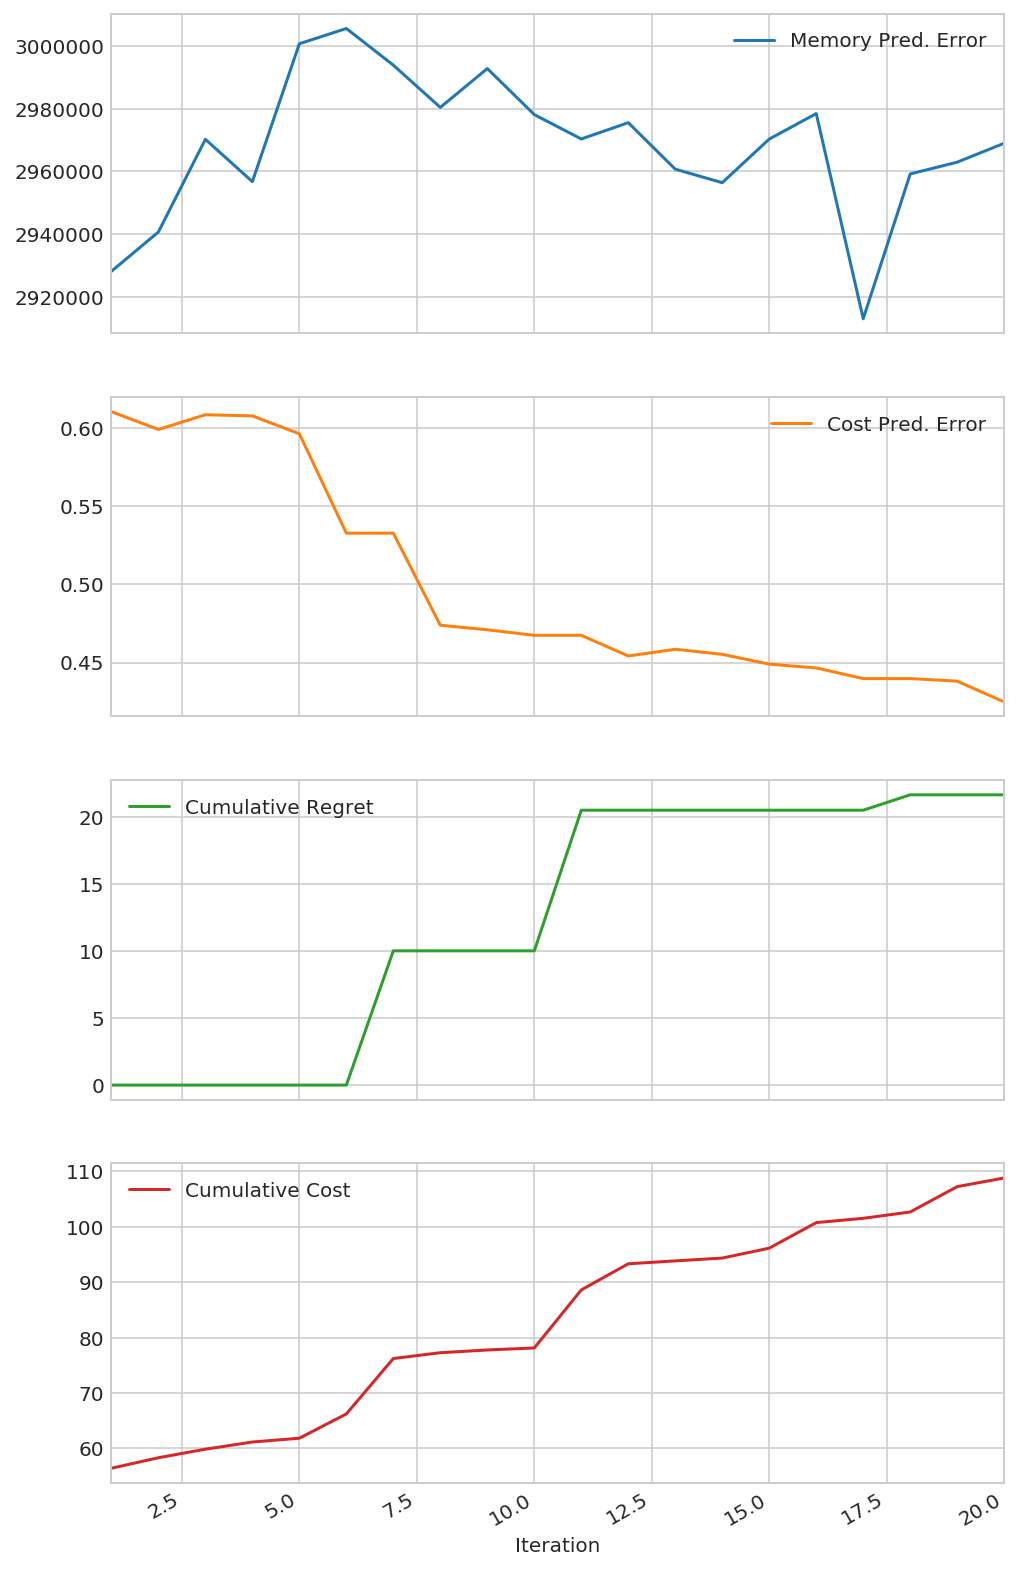

In [16]:
stop_after = 20

mem_limit_rel = 0.95
mem_limit_abs = jobs[mem_response].max() * mem_limit_rel

jobs_init, jobs_active, jobs_test = get_partition(jobs, n_init_rel=0.1, mem_limit_rel=mem_limit_rel)
gpr_cost = init_learn(jobs_init, opt_restarts = 5)
gpr_memory = init_learn(jobs_init, response=mem_response, opt_restarts = 3)

# Note: value for "stop_after_iter" should be >=record_predictions_at+1
kwargs = {"init": jobs_init,
          "active": jobs_active,
          "test": jobs_test,
          "gpr_cost": gpr_cost,
          "gpr_memory": gpr_memory,
          "reuse_kernel": True,
          "restarts": 3,
          "stop_after_iter": stop_after,
          "function": RGMA,
          "mem_limit_abs": mem_limit_abs,
          "label": "RGMA",
          "record_predictions_at": stop_after,
          "verbose": True}
res = active_learn(**kwargs)

to_plot = ["Memory Pred. Error", "Cost Pred. Error", "Cumulative Regret", "Cumulative Cost", "Iteration"]
res["summary"][to_plot].plot.line(x="Iteration", subplots=True, figsize=(8, 3*len(to_plot)));

Saved plot as: /notebooks/ActiveLearning-For-AMR/active-shockbubble/log/20180225_183635/heatmap.pdf


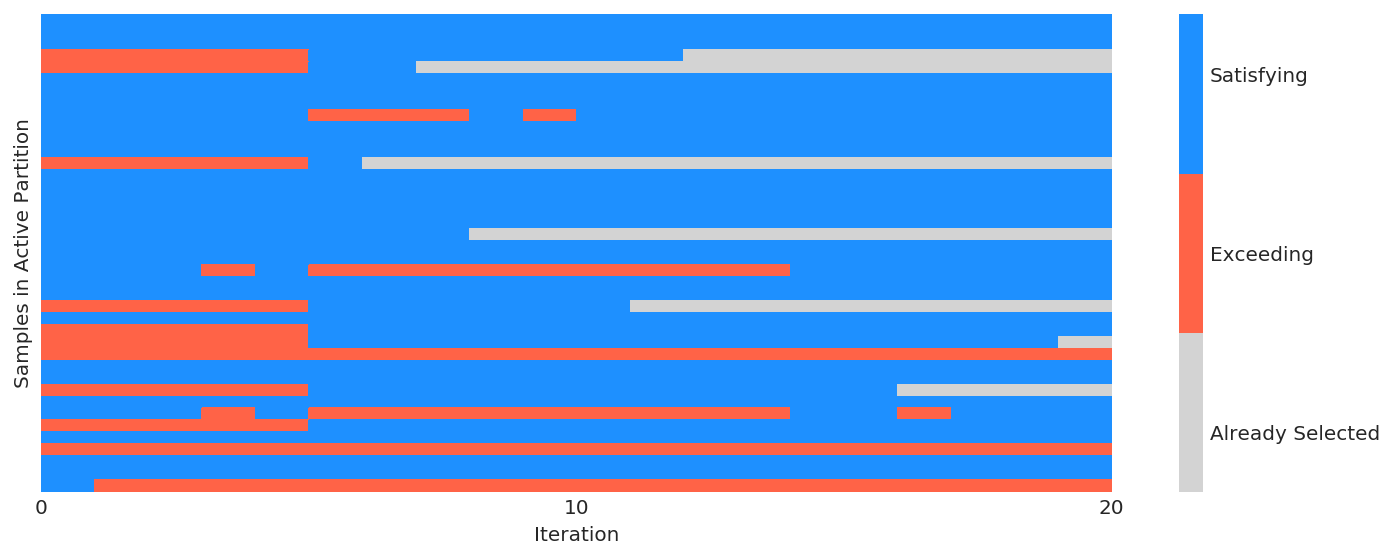

In [17]:
# Produce a heatmap showing the change in candidate classification: satisfying or exceeding set memory limit

map_pivoted = res["hash_map"].pivot(index='Iteration', columns='Hash', values='Satisfying')

# Select columns/samples with the most change
sample_limit = 40
sample_list = (map_pivoted - \
               map_pivoted.shift()).T.fillna(0).abs().sum(axis=1).sort_values(ascending=False).index.values[:sample_limit]

map_selected = map_pivoted[map_pivoted.columns.intersection(sample_list)]

# Map values for convenient plotting: NaN -> -1 (gray), False -> 0 (red), True -> 1 (green)
plot_map = (map_selected.fillna(-1.0) + 0.0).convert_objects(convert_numeric=True).T

# Shuffle
plot_map.set_index(np.arange(len(plot_map)), inplace=True)
plot_map = plot_map.reindex(np.random.permutation(len(plot_map))).set_index(np.arange(len(plot_map)))

fig, ax = plt.subplots(figsize=(10, 4)) 
sns.heatmap(plot_map, cmap=ListedColormap(['lightgray', 'tomato', 'dodgerblue']), annot=False, ax=ax)

# Additional styling
ax.set_yticks([])
ax.set_ylabel("Samples in Active Partition")

cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.75, 0, 0.75])
cbar.set_ticklabels(['Already Selected', 'Exceeding', 'Satisfying'])

iter_max = res["hash_map"]["Iteration"].max()
x_vals = np.arange(0, iter_max+1, 10)
ax.set_xticks(x_vals)
ax.set_xticklabels(x_vals)
for item in ax.get_xticklabels():
    item.set_rotation(0)

fig.tight_layout()

save_and_show(fig, "heatmap.pdf", out_dir)

### Experiment 2: Run a batch of "trajectories" for a set of Active Learning algorithms in parallel

In [18]:
# Running a batch takes a long time

#selection_func = RGMA
#selection_func = MinPred
#selection_func = RandGoodness
#selection_func = MaxSigma
selection_func = RandUniform

selection_func_label = str(selection_func).split()[1]

# reps = 32
reps = 4

stop_after = 400
mem_limit_rel = 0.95

#n_init_rel = 0.0025
#n_init_rel = 0.125
n_init_rel = 0.25

mem_limit_abs = jobs[mem_response].max() * mem_limit_rel

def single_trajectory(rep):
    # Make each worker use unique seed
    np.random.seed()

    jobs_init, jobs_active, jobs_test = get_partition(jobs, n_init_rel=n_init_rel, mem_limit_rel=mem_limit_rel)
    gpr_cost = init_learn(jobs_init, opt_restarts = 3)
    gpr_memory = init_learn(jobs_init, response=mem_response, opt_restarts = 3)

    # Note: value for "stop_after_iter" should be >=record_predictions_at+1
    kwargs = {"init": jobs_init,
              "active": jobs_active,
              "test": jobs_test,
              "gpr_cost": gpr_cost,
              "gpr_memory": gpr_memory,
              "reuse_kernel": True,
              "restarts": 3,
              "stop_after_iter": stop_after,
              "function": selection_func,
              "label": selection_func_label,
              "mem_limit_abs": mem_limit_abs,
              "record_predictions_at": stop_after,
              "verbose": rep == 0}
    res = active_learn(**kwargs)

    # Add parameters of the trajectory to the dataframe 
    res["summary"]["rep"] = rep
    res["summary"]["Candidate Selection"] = selection_func_label  
    res["summary"]["mem_limit_rel"] = mem_limit_rel  
    res["summary"]["n_init_rel"] = n_init_rel  
    
    return res
    
# Allows for the safe importing of the main module (needed by multiprocessing)
if __name__ == '__main__':
    tasks = range(reps)
    
    startTime = time.time()
    
    p = mp.Pool(mp.cpu_count())
    print "Starting to run trajectories on %d processors" % mp.cpu_count()
    tasks_output = p.map(single_trajectory, tasks)
    print "All tasks completed."
    
    endTime = time.time()
    
    # Construct summary dataframe with all results
    batch = pd.DataFrame()
    for out in tasks_output:
        batch = pd.concat([batch, out["summary"]])
    print "Number of rows in summary:", len(batch)   
    
    batch_timestamp = (datetime.datetime.now()).strftime("%Y%m%d_%H%M%S")
    dest_file = os.path.join(out_dir, 'batch-%s-%s-%.4frinit-%drep.csv' % 
                             (batch_timestamp, selection_func_label, n_init_rel, reps))
    batch.to_csv(dest_file)
    print "Batch information saved to: %s" % dest_file
    
    p.terminate()
    
    print "Finished running %d trajectories in (seconds): %.3f" % (reps, endTime-startTime)

Starting to run trajectories on 16 processors


Completed iteration: 300/400
Completed AL with candidate selection defined in: <function RandUniform at 0x7f25d122c488>


All tasks completed.
Number of rows in summary: 1200
Batch information saved to: /notebooks/ActiveLearning-For-AMR/active-shockbubble/log/20180225_183635/batch-20180225_190524-RandUniform-0.2500rinit-4rep.csv
Finished running 4 trajectories in (seconds): 1700.400


Plot is saved to:
/notebooks/ActiveLearning-For-AMR/active-shockbubble/log/20180225_183635/batch-RandUniform-4rep-400iter.png


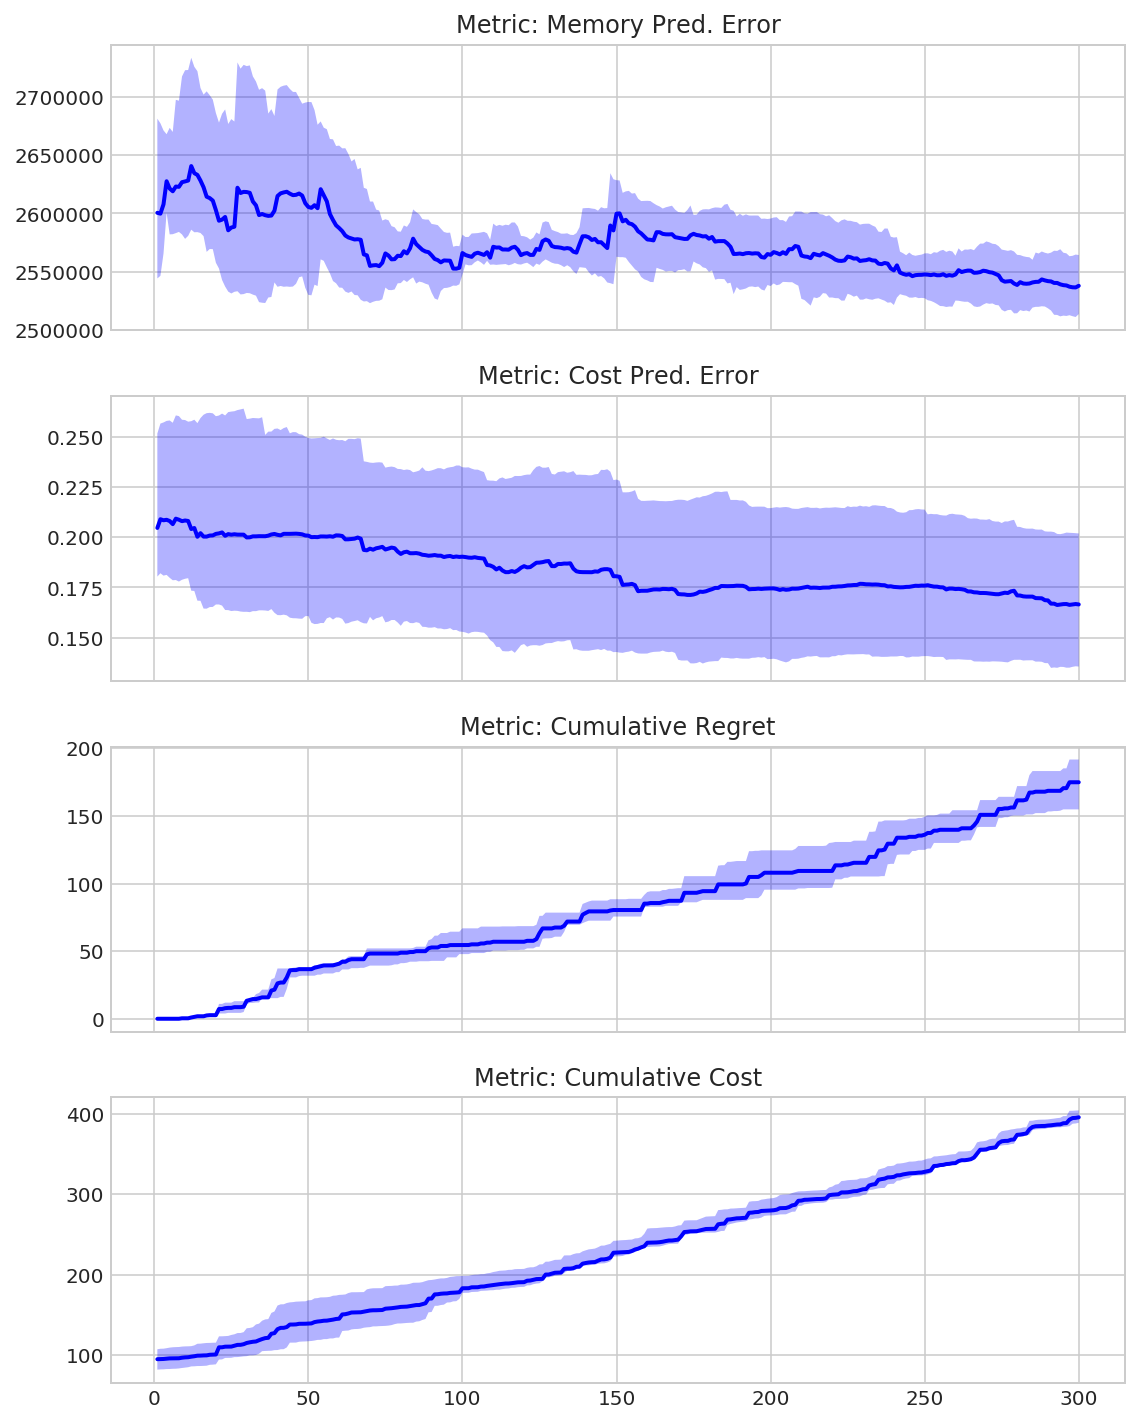

In [19]:
# Visualize data in the processed batch
# show_indiv: True (trajectories shown as lines) or False (medians and IQRs are shown)

show_list = ["Memory Pred. Error", "Cost Pred. Error", "Cumulative Regret", "Cumulative Cost"]
show_indiv = False
def_col = "blue"

fig, axs = plt.subplots(len(show_list), 1, sharex=True, 
                        figsize=(8, 2.5 * len(show_list)))

for (metric, ax) in zip(show_list, [axs] if len(show_list) == 1 else axs.flat):
    if show_indiv:
        for rep, grp in batch.groupby(["rep"]):
            grp.plot(x='Iteration', title ="Metric: %s" % metric,  y=metric, legend=False, lw=1.0, c=def_col, ax=ax)
    else:
        ax.set_title("Metric: %s" % metric)
        
        # Show median
        grp_iter = batch.groupby(['Iteration'])
        med = grp_iter.median() 
        ax.plot(med.index.values, med[metric], lw = 2.0, c=def_col, alpha = 1.0)

        # Show IQRs
        lb = grp_iter[metric].quantile([.25])
        ub = grp_iter[metric].quantile([.75])
        ax.fill_between(med.index.values, lb, ub, facecolor=def_col, alpha=0.3) 
fig.tight_layout()

dest_file = os.path.join(out_dir, 'batch-%s-%drep-%diter.png' % 
                             (str(selection_func).split()[1], reps, stop_after))
fig.savefig(dest_file, dpi=600)
print "Plot is saved to:\n%s" % dest_file